# Data Gather

### **library imports**

In [1]:
import cv2
import mediapipe as mp
import numpy as np
import csv
from scipy.signal import butter, filtfilt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
import pandas as pd
import matplotlib.pyplot as plt
import time
import os  # Add import for os module
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV, cross_val_score
from xgboost import XGBClassifier

### **Initialize MediaPipe Pose**

In [2]:
mp_pose = mp.solutions.pose  # Access MediaPipe's pose solution
mp_drawing = mp.solutions.drawing_utils  # Utility for drawing landmarks on frames
pose = mp_pose.Pose(
    static_image_mode=False,  # Process video frames in a continuous stream
    min_detection_confidence=0.5,  # Minimum confidence for detecting landmarks
    min_tracking_confidence=0.5  # Minimum confidence for tracking landmarks
)

### **Function to calculate the angle between two points in the XOY plane**

In [3]:
def angle_from_origin_xoy(p1, p2):
    delta_x = p2[0] - p1[0]
    delta_y = p1[1] - p2[1]  # Invert y-axis for Cartesian coordinates
                
    if delta_x == 0 and delta_y == 0:
        return 0.0  # Handle identical points
                
    angle = np.degrees(np.arctan2(delta_y, delta_x))
    angle = abs(angle)  # Convert -180 to -90 to 90 to 180
    if angle > 90:  # Second and third quadrants
        angle = 180 - angle  # Map 90-180 to 90-0            
    return angle

### **Function to process video and calculate angles**

In [4]:
def process_video_and_calculate_angles(video_path, landmark_to_compare,landmark_name, classification_class):
    """
    Process a video to calculate angles between a reference point and a specified landmark.
    Args:
        video_path (str): Path to the input video file.
        landmark_to_compare (int): Index of the landmark to compare against the reference point.
    """

    #Calculate angles and store them
    angles_data = []
    
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error opening video.")
        return

    fps = int(cap.get(cv2.CAP_PROP_FPS))
    scale = (800, 600)
    frame_atual = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret or frame is None:
            print("End of video or cannot read the frame.")
            break

        imagem_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        resultado = pose.process(imagem_rgb)

        if resultado.pose_landmarks:
            mp_drawing.draw_landmarks(frame, resultado.pose_landmarks, mp_pose.POSE_CONNECTIONS)

            # Get reference point (midpoint between hips)
            left_hip = resultado.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_HIP]
            right_hip = resultado.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_HIP]
            ref_x = (left_hip.x + right_hip.x) / 2
            ref_y = (left_hip.y + right_hip.y) / 2

            # Use the index directly to get the specified landmark
            target_landmark = resultado.pose_landmarks.landmark[int(landmark_to_compare)]

            # Convert normalized coordinates to image coordinates
            h, w, _ = frame.shape
            ref_pt = (int(ref_x * w), int(ref_y * h))
            target_pt = (int(target_landmark.x * w), int(target_landmark.y * h))

            # Draw points
            cv2.circle(frame, ref_pt, 8, (0, 255, 0), -1)
            cv2.circle(frame, target_pt, 8, (0, 0, 255), -1)

            # Draw line
            cv2.line(frame, ref_pt, target_pt, (255, 255, 0), 2)

            # Calculate angle
            angulo = angle_from_origin_xoy(ref_pt, target_pt)

            if angulo is not None:
                # Save the angle and frame number to the list
                angles_data.append((frame_atual, angulo,classification_class))

                # Display angle
                cv2.putText(frame, f"Angle: {angulo:.1f} deg", (target_pt[0]+10, target_pt[1]-10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2, cv2.LINE_AA)
            else:
                # Log a message if the angle is None
                print(f"Frame {frame_atual}: Unable to calculate angle.")

        frame_resized = cv2.resize(frame, scale)
        cv2.imshow("Angle Visualization", frame_resized)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

        frame_atual += 1
    cap.release()
    cv2.destroyAllWindows()
    
    csv_path = f"{video_path}_{landmark_name}_angles.csv"
    # Save angles and frame numbers to a CSV file
    with open(csv_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Frame", "Angle (degrees)", "Classification"])
        writer.writerows(angles_data)

    print(f"Angles and frame numbers saved to {csv_path}")


### **Function to process csv and normalize data**

In [5]:
def analyze_csv(csv_file_path): # type: ignore
    """
    Analyze the CSV file to filter angles, calculate velocity, and acceleration.
    Args:
        csv_file_path (str): Path to the input CSV file.
        output_file_path (str): Path to save the processed CSV file.
    """
    # Load the CSV file
    data = pd.read_csv(csv_file_path)

    # Butterworth low-pass filter function
    def butter_lowpass_filter(data, cutoff, fs, order):
        b, a = butter(order, cutoff, btype='low', analog=False)
        return filtfilt(b, a, data)

    # Define filter parameters
    order = 4
    cutoff = 0.2
    fps = 30

    # Apply the filter to the Angle (degrees) column
    data['Filtered Angle (degrees)'] = butter_lowpass_filter(data['Angle (degrees)'], cutoff, fps, order)

    # Calculate velocity and acceleration
    data['velocity'] = np.gradient(data['Filtered Angle (degrees)'], data['Frame'])
    data['acceleration'] = np.gradient(data['velocity'], data['Frame'])

    # Normalize velocity and acceleration
    scaler = MinMaxScaler()
    data[['velocity_normalized', 'acceleration_normalized']] = scaler.fit_transform(
        data[['velocity', 'acceleration']]
    )

    # Add a new column to convert frames to seconds
    data['Time (seconds)'] = data['Frame'] / fps

    # Save the updated DataFrame to a new CSV file
    data.to_csv(csv_file_path+"_processed", index=False)
    print("Processed data saved to " + csv_file_path + "_processed.csv")

### **Define the landmarks of interest**

In [6]:
landmarks_ids = {
    "head": 0,  # Head (nose landmark)
    "left_wrist": 15,  # Left wrist
    "right_wrist": 16,  # Right wrist
    "left_ankle": 27,  # Left ankle
    "right_ankle": 28  # Right ankle
}
print("Landmarks de interesse definidos:", landmarks_ids)


Landmarks de interesse definidos: {'head': 0, 'left_wrist': 15, 'right_wrist': 16, 'left_ankle': 27, 'right_ankle': 28}


### **Gather data from videos**

In [ ]:
videos = {
    'C:\\Users\\asus\\Desktop\\work\\Videos\\impro_free.MP4': 'direct',
    'C:\\Users\\asus\\Desktop\\work\\Videos\\Phrase3.mp4': 'indirect',
}

def calculate_landmarks_for_videos(videos, landmarks):
    for video_path, classification in videos.items():
        for landmark_name, landmark_index in landmarks.items():
            process_video_and_calculate_angles(video_path, landmark_to_compare=landmark_index, landmark_name=landmark_name, classification_class=classification)
            analyze_csv(csv_file_path=f"{video_path}_{landmark_name}_angles.csv")

calculate_landmarks_for_videos(videos, landmarks_ids)

### **Join frames to get STD e Medium**

In [ ]:
import glob

video_folder = os.path.dirname(list(videos.keys())[0])
processed_csv_paths = glob.glob(os.path.join(video_folder, "*processed"))

summary_stats = []

for csv_path in processed_csv_paths:
    df = pd.read_csv(csv_path)
    # Group by each second
    grouped = df.groupby(df['Time (seconds)'].astype(int))
    stats = grouped.agg({
        'Filtered Angle (degrees)': ['std', 'mean', 'median', 'min', 'max'],
        'velocity': ['std', 'mean', 'median', 'min', 'max'],
        'acceleration': ['std', 'mean', 'median', 'min', 'max']
    }).reset_index()
    # Flatten MultiIndex columns
    stats.columns = ['Time (seconds)',
                     'angle_std', 'angle_medium', 'angle_median', 'angle_min', 'angle_max',
                     'velocity_std', 'velocity_medium', 'velocity_median', 'velocity_min', 'velocity_max',
                     'acceleration_std', 'acceleration_medium', 'acceleration_median', 'acceleration_min', 'acceleration_max']
    stats['Classification'] = df['Classification']
    summary_stats.append(stats)
    # Save per-file stats
    stats_path = csv_path + "_persecond_stats.csv"
    stats.to_csv(stats_path, index=False)

# Concatenate all stats
df_stats = pd.concat(summary_stats, ignore_index=True)
print(df_stats.head())



### **Join all processed CSV files from the videos folder**

In [9]:
# Find all files ending with '_stats.csv' in the video folder
stats_files = glob.glob(os.path.join(video_folder, "*_stats.csv"))

# Read and concatenate all stats files
df_all_stats = pd.concat([pd.read_csv(f) for f in stats_files], ignore_index=True)



### **Save the concatenated DataFrame to a new CSV file**

In [10]:
# Save the combined stats DataFrame to a CSV file
all_stats_csv_path = os.path.join(video_folder, "all_landmarks_stats_combined.csv")
df_all_stats.to_csv(all_stats_csv_path, index=False)
print(f"Combined stats CSV saved to: {all_stats_csv_path}")

Combined stats CSV saved to: C:\Users\asus\Desktop\work\Videos\all_landmarks_stats_combined.csv


### **Print DataFrame statistics**

In [ ]:
df_all_stats.describe(include='all')

In [ ]:
df_all_stats.info()

# Training

### **Necessary Imports**

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

### **Gather all processed CSVs and Split Data for Training**

In [3]:
# Load combined stats CSV
df_all = pd.read_csv(os.path.join("C:\\Users\\asus\\Desktop\\work\\Videos\\all_landmarks_stats_combined.csv"))
# Features and target
X = df_all[['angle_std', 'angle_medium', 'angle_median', 'angle_min', 'angle_max',
            'velocity_std', 'velocity_medium', 'velocity_median', 'velocity_min', 'velocity_max',
            'acceleration_std', 'acceleration_medium', 'acceleration_median', 'acceleration_min', 'acceleration_max']]
y = df_all['Classification']

scaler = StandardScaler()

In [ ]:
# Separate classes
df_direct = df_all[df_all['Classification'] == 'direct']
df_indirect = df_all[df_all['Classification'] == 'indirect']

# Resample to balance classes
df_direct_resampled = resample(df_direct, replace=True, n_samples=len(df_indirect), random_state=42)
df_balanced = pd.concat([df_direct_resampled, df_indirect])

# Shuffle the dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Define features and target for balanced data
X_balanced = df_balanced[X.columns]
y_balanced = df_balanced['Classification']

# Split balanced data
Xb_train, Xb_test, yb_train, yb_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Correct scaling process
scaler = StandardScaler()
Xb_train = scaler.fit_transform(Xb_train)  # Fit and transform training data
Xb_test = scaler.transform(Xb_test)       # Transform test data using the same scaler

### **Create and Build Model**

In [6]:
# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(Xb_train, yb_train)

# Predict and report
yb_pred = rf.predict(Xb_test)

### **Test Model**

              precision    recall  f1-score   support

      direct       0.94      0.94      0.94        18
    indirect       0.93      0.93      0.93        14

    accuracy                           0.94        32
   macro avg       0.94      0.94      0.94        32
weighted avg       0.94      0.94      0.94        32



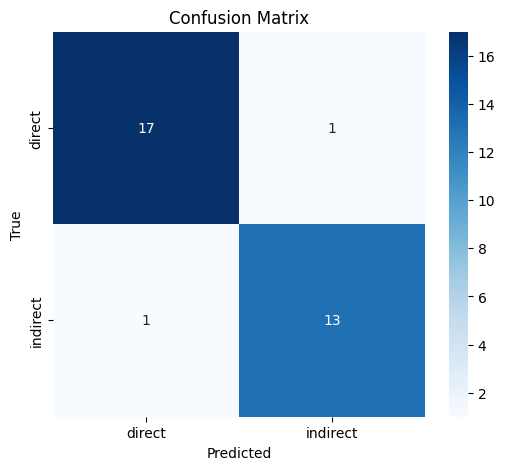

Feature Importances:
acceleration_std: 0.1220
angle_max: 0.1079
velocity_std: 0.0936
velocity_min: 0.0799
velocity_max: 0.0783
acceleration_max: 0.0770
acceleration_min: 0.0683
angle_medium: 0.0656
angle_min: 0.0577
angle_std: 0.0537
acceleration_median: 0.0436
velocity_median: 0.0420
velocity_medium: 0.0403
angle_median: 0.0368
acceleration_medium: 0.0333


C:\Users\asus\AppData\Local\Temp\ipykernel_50396\4073093794.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[f[1] for f in sorted_features], y=[f[0] for f in sorted_features], palette="viridis")


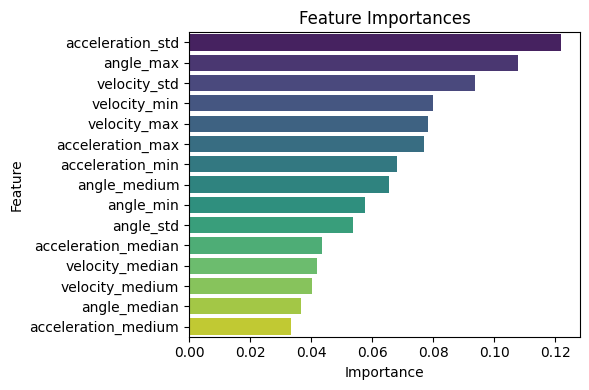

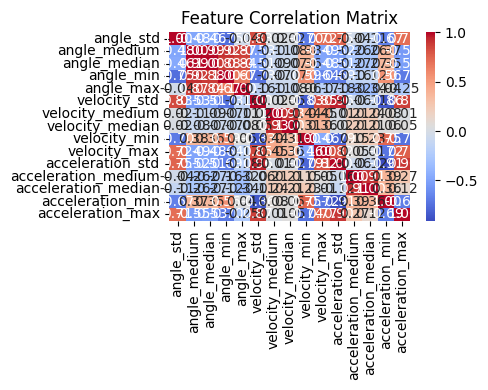

In [7]:
print(classification_report(yb_test, yb_pred))

# Calculate confusion matrix
cm = confusion_matrix(yb_test, yb_pred)

# Confusion matrix plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Feature importances
importances = rf.feature_importances_
feature_names = X.columns
feature_importance_dict = dict(zip(feature_names, importances))
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
print("Feature Importances:")
for feature, importance in sorted_features:
    print(f"{feature}: {importance:.4f}")

# Plot feature importances
plt.figure(figsize=(6, 4))
sns.barplot(x=[f[1] for f in sorted_features], y=[f[0] for f in sorted_features], palette="viridis")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importances")
plt.tight_layout()
plt.show()

# Plot correlation matrix of features
plt.figure(figsize=(5, 4))
corr = X.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

### **Create and Build Model with Hyperparameter Tuning**

In [8]:
# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search using the balanced and scaled data
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='accuracy')
grid_search.fit(Xb_train, yb_train)

# Use the best model
rf = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")

# Predict and report
y_pred = rf.predict(Xb_test)

Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


### **Test Model with Hyperparameter Tuning**

              precision    recall  f1-score   support

      direct       0.94      0.94      0.94        18
    indirect       0.93      0.93      0.93        14

    accuracy                           0.94        32
   macro avg       0.94      0.94      0.94        32
weighted avg       0.94      0.94      0.94        32



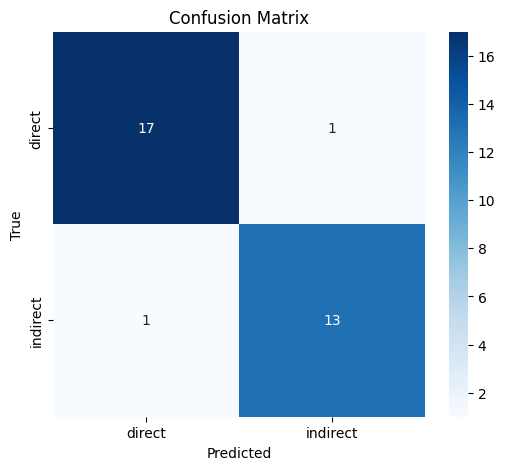

Feature Importances:
acceleration_std: 0.1397
angle_max: 0.1163
velocity_std: 0.0926
velocity_min: 0.0763
velocity_max: 0.0705
acceleration_max: 0.0683
acceleration_min: 0.0628
angle_std: 0.0617
angle_min: 0.0614
angle_medium: 0.0595
angle_median: 0.0476
acceleration_medium: 0.0396
acceleration_median: 0.0362
velocity_medium: 0.0350
velocity_median: 0.0324


C:\Users\asus\AppData\Local\Temp\ipykernel_50396\1657999214.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[f[1] for f in sorted_features], y=[f[0] for f in sorted_features], palette="viridis")


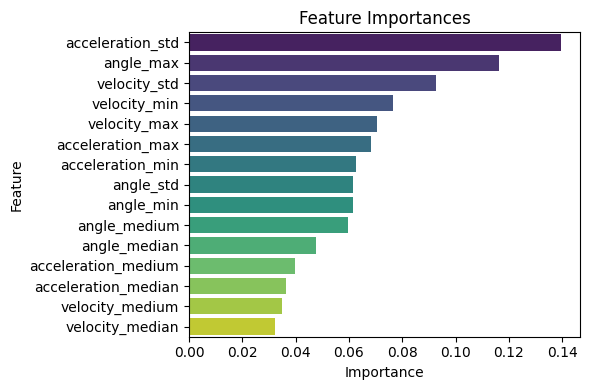

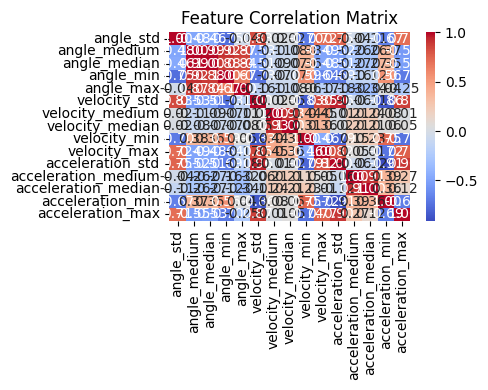

In [9]:
print(classification_report(yb_test, y_pred))

# Calculate confusion matrix
cm = confusion_matrix(yb_test, y_pred)

# Confusion matrix plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Feature importances
importances = rf.feature_importances_
feature_names = X.columns
feature_importance_dict = dict(zip(feature_names, importances))
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
print("Feature Importances:")
for feature, importance in sorted_features:
    print(f"{feature}: {importance:.4f}")

# Plot feature importances
plt.figure(figsize=(6, 4))
sns.barplot(x=[f[1] for f in sorted_features], y=[f[0] for f in sorted_features], palette="viridis")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importances")
plt.tight_layout()
plt.show()

# Plot correlation matrix of features
plt.figure(figsize=(5, 4))
corr = X.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

In [21]:
# Separate classes
df_direct = df_all[df_all['Classification'] == 'direct']
df_indirect = df_all[df_all['Classification'] == 'indirect']

# Resample to balance classes
df_direct_resampled = resample(df_direct, replace=True, n_samples=len(df_indirect), random_state=42)
df_balanced = pd.concat([df_direct_resampled, df_indirect])

# Shuffle the dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

### **Try XGBoost Model**

              precision    recall  f1-score   support

      direct       0.67      0.50      0.57         8
    indirect       0.78      0.88      0.82        16

    accuracy                           0.75        24
   macro avg       0.72      0.69      0.70        24
weighted avg       0.74      0.75      0.74        24



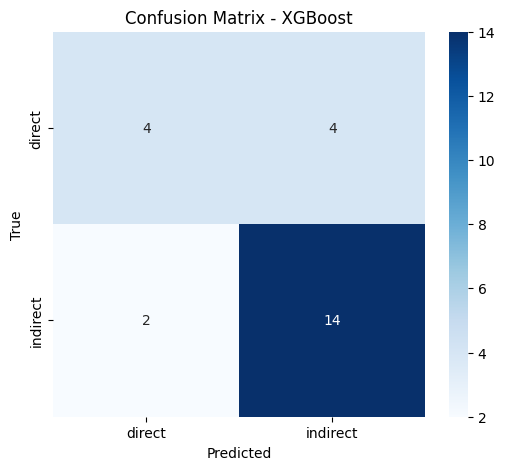

Feature Importances (XGBoost):
acceleration_std: 0.1802
angle_min: 0.1386
angle_std: 0.1017
velocity_max: 0.0917
velocity_std: 0.0713
acceleration_max: 0.0632
acceleration_min: 0.0545
velocity_min: 0.0518
angle_max: 0.0484
velocity_medium: 0.0436
angle_medium: 0.0393
velocity_median: 0.0312
angle_median: 0.0302
acceleration_median: 0.0279
acceleration_medium: 0.0265


C:\Users\asus\AppData\Local\Temp\ipykernel_32172\2946185081.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[f[1] for f in sorted_features], y=[f[0] for f in sorted_features], palette="viridis")


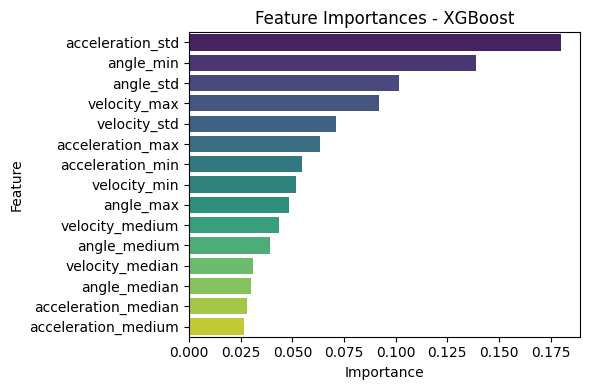

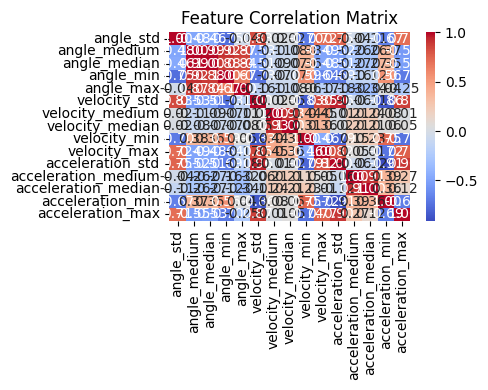

In [22]:
# Encode target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Train XGBoost
xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb.fit(X_train, y_train_encoded)

# Predict and evaluate
y_pred_encoded = xgb.predict(X_test)
y_pred = label_encoder.inverse_transform(y_pred_encoded)

print(classification_report(y_test, y_pred))

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Confusion matrix plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - XGBoost')
plt.show()

# Feature importances
importances = xgb.feature_importances_
feature_names = X.columns
feature_importance_dict = dict(zip(feature_names, importances))
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
print("Feature Importances (XGBoost):")
for feature, importance in sorted_features:
    print(f"{feature}: {importance:.4f}")

# Plot feature importances
plt.figure(figsize=(6, 4))
sns.barplot(x=[f[1] for f in sorted_features], y=[f[0] for f in sorted_features], palette="viridis")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importances - XGBoost")
plt.tight_layout()
plt.show()

# Plot correlation matrix of features
plt.figure(figsize=(5, 4))
corr = X.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()